# Analysis of diurnal wind features across the U.S. 

In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def readNOAA_ISH(USAF, WBAN, year):
    """This function reads data from NOAA ISH data files for U.S.
    cities used for CONTAM modeling in the EPA indoor air quality
    project.
    
    Input:
        USAF - USAF station identifier  (as a string)
        WBAN - WBAN station identifier  (as a string)
        year - Desired year, e.g., 2010 (as an integer)

    Written by Von P. Walden, Washington State University
               12 Nov 2017

    """
    def pressureCorrection(Ps, Hstn, Tstn):
        """Calculate the station pressure in hPa from the sea-level pressure
        (Ps) and the station temperature (Tstn). The correction comes from
        http://www.weather.gov/media/epz/wxcalc/stationPressure.pdf. This
        correction was quickly checked against the hypsometric equation and was
        shown to be adequate; see pressureCorrectionTest.py.
        
        Inputs:
            Hstn - elevation (height) of weather station (meters)
            Ps   - sea-level pressure in Pa
            Tstn - temperature measured at the weather station (K)
        
        Output:
            Atmospheric pressure at the weather station
            
        Written by Von P. Walden, Washington State University
                    19 November 2017
        """
        Lrate = 0.0065*Hstn     # LRate is the approximate lapse rate (K m-1)
        return Ps*((Tstn - Lrate)/Tstn)**5.2561
    
    # NOAA ISH parser comes from:
    #    https://github.com/haydenth/ish_parser
    from ish_parser import ish_parser
    import pandas as pd
    import numpy  as np
    
    # Construct filename of the desired data and read entire file.
    fn      = '/Volumes/vonw/data/iaq/NCDC/ish/3505v2' + USAF + '-' + WBAN + str(year) + '.op'
    f       = open(fn)
    content = f.read()
    f.close()
    
    # Read the observations from the desired file.
    wf   = ish_parser()
    wf.loads(content)
    obs  = wf.get_observations()

    # Create a datetime index.
    #
    time = np.array([ob.datetime for ob in obs])

    # ............................... WEATHER DATA ............................
    #
    Hstn = np.array([ob.elevation for ob in obs])                               # meters
    T    = np.array([ob.air_temperature.get_numeric() for ob in obs])           # deg C
    Ps   = np.array([ob.sea_level_pressure.get_numeric() for ob in obs])*100.   # Pa
    Pb   = pressureCorrection(Ps, Hstn, T+273.15)                               # Pa
    wspd = np.array([ob.wind_speed.get_numeric() for ob in obs])                # m s-1 
    wdir = np.array([ob.wind_direction.get_numeric() for ob in obs])            # degrees
    # Conversion from relative humidity to mixing ration 
    #    ....http://www.vaisala.com/Vaisala%20Documents/Application%20notes/Humidity_Conversion_Formulas_B210973EN-F.pdf
    A    = 6.116441
    m    = 7.591386
    Tn   = 240.7263
    es   = A*10**(m*(T)/(T+Tn))
    ws   = 0.622 * (es/Pb)
    w    = np.array([ob.humidity.get_numeric() for ob in obs]) * ws * 1000.     # Factor of 1000 converts from kg/kg to g/kg.
    # Calculation of air density
    Rd   = 287.                                                                 # Gas constant for dry air; J kg-1 K-1
    rho  = Pb / (Rd * (T+273.15))
    # Create a pandas DataFrame that contains the weather data.
    wth   = pd.DataFrame({'Ta'       : T+273.15,
                          'Pb'       : Pb,
                          'Ws'       : wspd,
                          'Wd'       : wdir,
                          'Hr'       : w,
                          'rho'      : rho,
                          'elevation': Hstn},
                          index=time)
    
    # Resample the dataframe to an hourly time step.
    wth = wth.resample('H').mean()
    
    return wth



In [3]:
stations = pd.read_csv('/Volumes/vonw/data/iaq/NCDC/ish/isd-history-IAQ.csv')

In [4]:
stations

,CITY,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,Chicago,725300,94846,CHICAGO O'HARE INTERNATIONAL AIRPORT,US,IL,KORD,41.995,-87.934,201.8,19461001,20171107
1,Cincinnati,724210,93814,CINCINNATI/NORTHERN KENTUCKY INTL AP,US,KY,KCVG,39.044,-84.672,269.1,19730101,20171107
2,Nashville,723270,13897,NASHVILLE INTERNATIONAL AIRPORT,US,TN,KBNA,36.119,-86.689,182.9,19510101,20171108
3,Birmingham,722280,13876,BIRMINGHAM INTERNATIONAL AIRPORT,US,AL,KBHM,33.566,-86.745,187.5,19420801,20171107
4,NewYork,725030,14732,LA GUARDIA AIRPORT,US,NY,KLGA,40.779,-73.880,3.4,19730101,20171107
5,Buffalo,725280,14733,BUFFALO NIAGARA INTERNATIONAL AP,US,NY,KBUF,42.941,-78.736,218.2,19420201,20171107
6,Phoenix,722780,23183,PHOENIX SKY HARBOR INTL AIRPORT,US,AZ,KPHX,33.428,-112.004,337.4,19730101,20171107
7,Denver,725650,3017,DENVER INTERNATIONAL AIRPORT,US,CO,KDEN,39.833,-104.658,1650.2,19940718,20171107
8,Boston,725090,14739,GEN E L LOGAN INTERNATIONAL AIRPORT,US,MA,KBOS,42.361,-71.010,3.7,19431121,20171107
9,Worcester,725100,94746,WORCESTER REGIONAL AIRPORT,US,MA,KORH,42.271,-71.873,304.8,20100801,20171107


## CHICAGO

In [5]:
station = stations.iloc[0]

In [6]:
station

CITY                                         Chicago
USAF                                          725300
WBAN                                           94846
STATION NAME    CHICAGO O'HARE INTERNATIONAL AIRPORT
CTRY                                              US
STATE                                             IL
ICAO                                            KORD
LAT                                           41.995
LON                                          -87.934
ELEV(M)                                        201.8
BEGIN                                       19461001
END                                         20171107
Name: 0, dtype: object

In [7]:
wth = pd.DataFrame()
for year in np.arange(2004,2014):
    print(year)
    #if ((station.CITY=='Worcester') and (year<2010)): continue
    wth = pd.concat([wth, readNOAA_ISH(str(station.USAF), str(station.WBAN), year)])

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


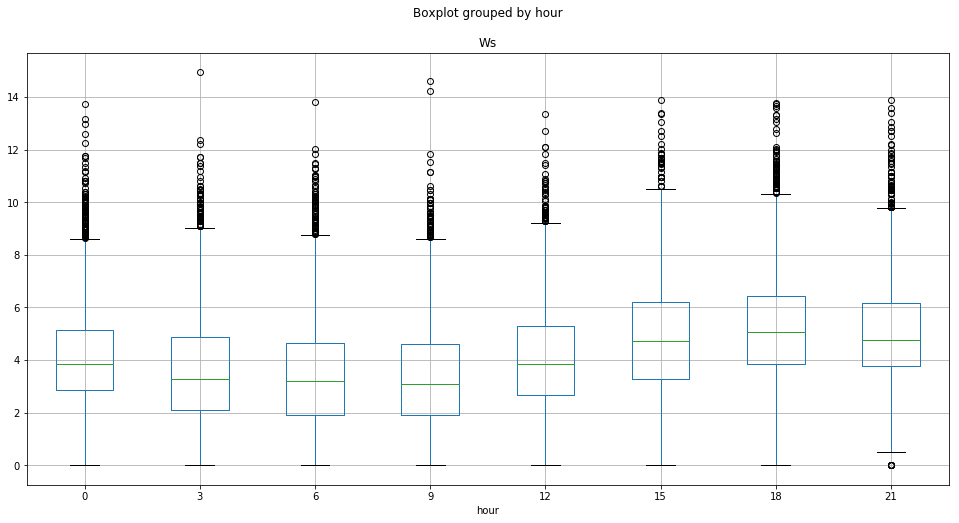

In [37]:
wth_3hr = wth.resample('3H').mean()
wth_3hr['hour'] = wth_3hr.index.hour
wth_3hr.boxplot(column=['Ws'], by='hour', figsize=(16,8))

In [62]:
morning = wth.between_time(start_time='00:00:00', end_time='07:00:00')
daytime = wth.between_time(start_time='08:00:00', end_time='15:00:00')
evening = wth.between_time(start_time='16:00:00', end_time='23:00:00')

Text(0.5,1,'Hourly wind data for Chicago')

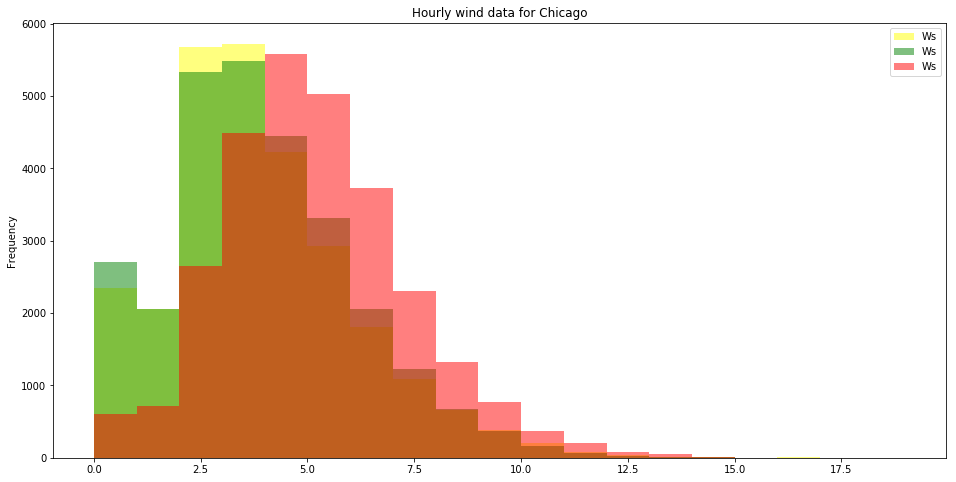

In [63]:
figure(figsize=(16,8))
morning.Ws.plot(kind='hist',bins=np.arange(0,20,1),alpha=0.5, color='yellow', legend='morning')
daytime.Ws.plot(kind='hist',bins=np.arange(0,20,1),alpha=0.5, color='green',  legend='daytime')
evening.Ws.plot(kind='hist',bins=np.arange(0,20,1),alpha=0.5, color='red',    legend='evening')
title('Hourly wind data for '+station.CITY)

## PHOENIX

In [38]:
station = stations.iloc[6]

In [39]:
station

CITY                                    Phoenix
USAF                                     722780
WBAN                                      23183
STATION NAME    PHOENIX SKY HARBOR INTL AIRPORT
CTRY                                         US
STATE                                        AZ
ICAO                                       KPHX
LAT                                      33.428
LON                                    -112.004
ELEV(M)                                   337.4
BEGIN                                  19730101
END                                    20171107
Name: 6, dtype: object

In [40]:
wth = pd.DataFrame()
for year in np.arange(2004,2014):
    print(year)
    #if ((station.CITY=='Worcester') and (year<2010)): continue
    wth = pd.concat([wth, readNOAA_ISH(str(station.USAF), str(station.WBAN), year)])

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


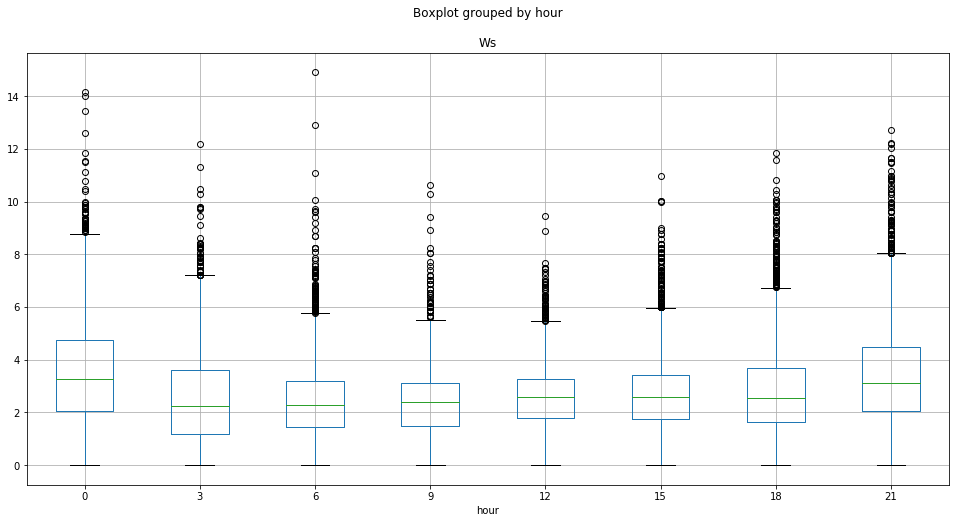

In [41]:
wth_3hr = wth.resample('3H').mean()
wth_3hr['hour'] = wth_3hr.index.hour
wth_3hr.boxplot(column=['Ws'], by='hour', figsize=(16,8))

In [42]:
morning = wth.between_time(start_time='00:00:00', end_time='07:00:00')
daytime = wth.between_time(start_time='08:00:00', end_time='15:00:00')
evening = wth.between_time(start_time='16:00:00', end_time='23:00:00')

Text(0.5,1,'Hourly wind data for Phoenix')

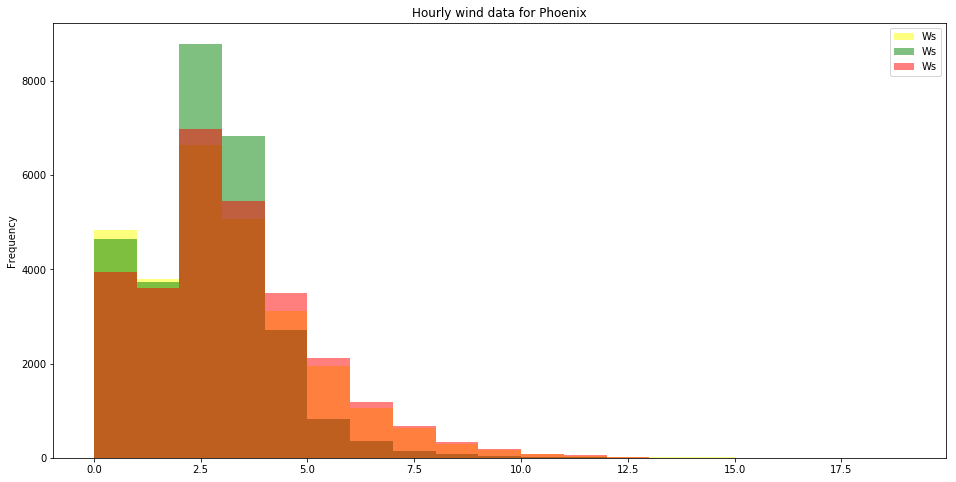

In [43]:
figure(figsize=(16,8))
morning.Ws.plot(kind='hist',bins=np.arange(0,20,1),alpha=0.5, color='yellow', legend='morning')
daytime.Ws.plot(kind='hist',bins=np.arange(0,20,1),alpha=0.5, color='green',  legend='daytime')
evening.Ws.plot(kind='hist',bins=np.arange(0,20,1),alpha=0.5, color='red',    legend='evening')
title('Hourly wind data for '+station.CITY)